### Load faqs (With IDs)

In [1]:
import json
import os
import pandas as pd
import numpy as np
from openai import OpenAI
from tqdm.auto import tqdm
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer

/home/daniel/llm/URA_RAG/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../data/faqs-with-ids.json','r') as faqs:
    faqs = json.load(faqs)

In [3]:
faqs

[{'question': 'What is Voluntary Disclosure?',
  'answer': 'Voluntary disclosure is a process where the taxpayer discloses information related to tax liabilities, misstatements or omissions his or her tax declarations to Uganda Revenue Authority (URA) without being prompted by any action or threat of action by URA.Please note that;A voluntary disclosure must be complete and accurate, covering all relevant periods where there was previously inaccurate, incomplete or unreported information regarding the taxpayer’s affairsA taxpayer who is subject to ongoing compliance action in respect of a given tax head and a particular tax period may nonetheless make voluntary disclosure in relation to a different tax head in the same or different period or the same tax head in a different period. This is allowed provided that the information that is disclosed would not inevitably have been discovered by the ongoing compliance action',
  'section': 'General FAQs',
  'id': 'fdff035c'},
 {'question': 'I

### Load Ground truth data

In [4]:
df_ground_truth_data = pd.read_csv('../data/ground-truth-data.csv')

df_ground_truth_data['faq'] = df_ground_truth_data['document']

df_ground_truth_data.drop(columns='answer',inplace=True)
df_ground_truth_data.drop(columns='document',inplace=True)

ground_truth = df_ground_truth_data.to_dict(orient='records')

In [5]:
ground_truth[4]

{'question': 'In what circumstances can a taxpayer not make a voluntary disclosure?',
 'faq': 'fdff035c'}

### Creating an Index

In [6]:
model_name='multi-qa-MiniLM-L6-cos-v1'
model=SentenceTransformer(model_name)

/home/daniel/llm/URA_RAG/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
es = Elasticsearch('http://localhost:9200')

In [8]:
index_settings = {
    "settings":{
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings":{
        "properties":{
            "question":{"type":"text"},
            "answer":{"type":"text"},
            "section":{"type":"text"},
            "id":{"type":"text"},
            "question_vector":{
                "type":"dense_vector",
                "dims":384,
                "index":True,
                "similarity":"cosine"
            },
            "answer_vector":{
                "type":"dense_vector",
                "dims":384,
                "index":True,
                "similarity":"cosine"
            },
            "question_answer_vector":{
                "type":"dense_vector",
                "dims":384,
                "index":True,
                "similarity":"cosine"
            }
        }
    }
}

index_name = "ura_faqs"


es.indices.delete(index=index_name,ignore_unavailable=True)
es.indices.create(index=index_name,body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'ura_faqs'})

In [9]:
for faq in tqdm(faqs):
    question = faq['question']
    answer = faq['answer']
    section = faq['section']
    id = faq['id']

    qa = question + ' '+ answer

    faq['question_vector'] = model.encode(question)
    faq['answer_vector'] = model.encode(answer)
    faq['question_answer_vector'] = model.encode(qa)

100%|██████████| 217/217 [00:28<00:00,  7.70it/s]


In [10]:
for faq in tqdm(faqs):
    es.index(index=index_name,document=faq)

100%|██████████| 217/217 [00:03<00:00, 57.60it/s]


### Retrieval

In [11]:
def elastic_search_hybrid(field, query,query_vector,index_name="ura_faqs"):
    knn_query = {
        "field": field,
        "query_vector": query_vector,
        "k": 1,
        "num_candidates": 10000,
        "boost": 0.5
    }

    keyword_query = {
        "bool": {
            "must": {
                "multi_match": 
                {
                    "query": query, 
                    "fields": ["question","answer","section","id"], 
                    "type": "best_fields", 
                    "boost": 0.5
                }
            },
        }
    }

    search_query = {
        "knn": knn_query,
        "query": keyword_query,
        "size": 5,
        "_source": ["question", "answer", "section","id"]
    }

    try:
        results = []

        es_results = es.search(index=index_name, body=search_query)
        result_docs = [hit['_source'] for hit in es_results['hits']['hits']]

        for i in result_docs:
            result = {
                        'id':i['id'],
                        'question': i['question'], 
                        'answer': i['answer'],  
                        'section': i['section']            
                    }
            results.append(result)
        return results
            
    except Exception as e:
        print(f"Error during hybrid search: {e}")
        return []


In [12]:
def faq_question(q):
    vq = model.encode(q)

    return elastic_search_hybrid("question_answer_vector", q, vq,index_name="ura_faqs")

In [13]:
faq_question('What is a Taxpayer Identification Number')

[{'id': '3eb2df58',
  'question': 'What is a TIN',
  'answer': 'Taxpayer Identification Number in Uganda is a unique identifying number assigned to every taxpayer by Uganda Revenue Authority (URA) for tax administration purposes. Any person who is likely to transact in any tax related business with URA, shall be required to apply for a TIN. The TIN is therefore an administrative requirement and applies to all taxpayers regardless of the taxtransaction.',
  'section': 'Domestic Taxes FAQs'},
 {'id': '996dccba',
  'question': 'HOW TO BECOME TAX COMPLIANT',
  'answer': 'What tax registrationrequirements must I fulfil?A person liable to pay tax shall apply to the Commissioner for registration in the prescribed manner. Upon registration, a person (individual or non-individual) shall be issued with a Taxpayer Identification Number (TIN). Every person registered for taxes is required to state their TIN on any return, notice, communication or any other document furnished, lodged or used for th

### RAG 

In [14]:
prompt_template = """
You're a Uganda Revenue Authority expert. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}
CONTEXT: 
{context}
""".strip()

entry_template="""
question:{question}
answer:{answer}
section:{section}
"""


def build_prompt(query, search_results):
    context = ""
    
    for faq in search_results:
        context = context + entry_template.format(**faq) +"\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [19]:
client = OpenAI(api_key=api_key)

In [20]:
def llm(prompt,model='gpt-4o-mini'):
    response = client.chat.completions.create(
        model=model,
        messages=[{
            "role":"user",
            "content":prompt
        }]
    )

    return response.choices[0].message.content

In [23]:
def rag(query):
    query_vector = model.encode(query)
    search_results = elastic_search_hybrid("question_answer_vector", query, query_vector,index_name="ura_faqs")
    prompt = build_prompt(query,search_results)
    answer = llm(prompt)
    return answer

### Evaluation

#### Recall at K (R@K):

**Definition**: Measures the proportion of relevant documents that are retrieved in the top K results.
**Formula**: 
```py
Recall = (Number of relevant documents retrieved) / (Total number of relevant documents)
```

In [24]:
def recall_at_k(relevance_total, k):
    total_recall = 0.0
    for line in relevance_total:
        total_relevant = sum(line)
        relevant_in_top_k = sum(line[:k])
        if total_relevant > 0:
            total_recall += relevant_in_top_k / total_relevant
    return total_recall / len(relevance_total)


#### Normalized Discounted Cumulative Gain (NDCG)

Definition: NDCG evaluates the relevance of the retrieved documents, with higher relevance scores assigned to documents at the top of the ranked list.
Formula: NDCG is based on Cumulative Gain (CG), Discounted Cumulative Gain (DCG), and normalized with Ideal Discounted Cumulative Gain (IDCG).
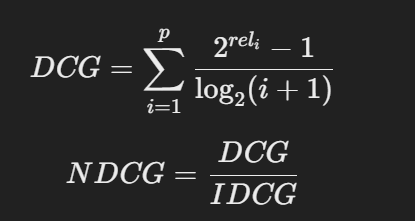
​


In [25]:
def dcg_at_k(relevance_scores, k):
    # Check if relevance_scores is a list of lists or nested structure
    if any(isinstance(i, list) for i in relevance_scores):
        print("Found a nested structure, flattening relevance scores")
        relevance_scores = [item for sublist in relevance_scores for item in sublist]
    
    # Convert to NumPy array
    relevance_scores = np.asarray(relevance_scores)[:k]

    # Check if the array is now homogeneous
    if relevance_scores.ndim > 1:
        raise ValueError("Relevance scores should be a 1D list or array")
    
    discounts = np.log2(np.arange(2, relevance_scores.size + 2))
    return np.sum(relevance_scores / discounts)

def ndcg_at_k(relevance_scores, k):
    dcg = dcg_at_k(relevance_scores, k)
    ideal_relevance = sorted(relevance_scores, reverse=True)
    ideal_dcg = dcg_at_k(ideal_relevance, k)
    return dcg / ideal_dcg if ideal_dcg > 0 else 0

####  Precision at K (P@K):
**Definition**: Measures the proportion of retrieved documents that are relevant in the top K results.
```py
P@k = (Number of relevant documents in top k results) / k
```

In [26]:
def precision_at_k(relevance_total, k):
    total_precision = 0.0
    for line in relevance_total:
        relevant_in_top_k = sum(line[:k])
        total_precision += relevant_in_top_k / k
    return total_precision / len(relevance_total)


#### MRR

In [27]:
def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

#### Hit Rate

In [28]:
def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

In [29]:
def evaluate(ground_truth,search_function):
    
    relevance_total=[]

    for question in tqdm(ground_truth):
        faq_id = question['faq']
        
        results = search_function(question)
        
        k=len(results)
        relevance=[faq['id'] == faq_id for faq in results]

        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
        'recall_at_k': recall_at_k(relevance_total,k),
        'ndcg_at_k': ndcg_at_k(relevance_total,k),
        'precision_at_k': precision_at_k(relevance_total,k)
    }

In [30]:
evaluate(ground_truth,lambda question: elastic_search_hybrid(
    'question_answer_vector',
    question['question'],
    model.encode(question['question'])))

100%|██████████| 1045/1045 [00:36<00:00, 28.36it/s]

Found a nested structure, flattening relevance scores
Found a nested structure, flattening relevance scores


{'hit_rate': 0.8947368421052632,
 'mrr': 0.7680542264752795,
 'recall_at_k': 0.8947368421052632,
 'ndcg_at_k': 0.0,
 'precision_at_k': 0.17894736842105063}

## Cosine Similarity

In [31]:
def rag_cosine(query,gpt_model):
    query_vector = model.encode(query)
    search_results = elastic_search_hybrid("question_answer_vector", query, query_vector,index_name="ura_faqs")
    prompt = build_prompt(query,search_results)
    answer = llm(prompt,gpt_model)
    return answer

In [32]:
answers = {}

In [33]:
rag_idx = {f['id']: f for f in faqs}
rag_idx

{'fdff035c': {'question': 'What is Voluntary Disclosure?',
  'answer': 'Voluntary disclosure is a process where the taxpayer discloses information related to tax liabilities, misstatements or omissions his or her tax declarations to Uganda Revenue Authority (URA) without being prompted by any action or threat of action by URA.Please note that;A voluntary disclosure must be complete and accurate, covering all relevant periods where there was previously inaccurate, incomplete or unreported information regarding the taxpayer’s affairsA taxpayer who is subject to ongoing compliance action in respect of a given tax head and a particular tax period may nonetheless make voluntary disclosure in relation to a different tax head in the same or different period or the same tax head in a different period. This is allowed provided that the information that is disclosed would not inevitably have been discovered by the ongoing compliance action',
  'section': 'General FAQs',
  'id': 'fdff035c',
  'qu

In [34]:
def process_faqs(gpt_model):
    for i, rec in enumerate(tqdm(ground_truth)):
        if i in answers:
            continue

        answer_llm = rag_cosine(rec['question'],gpt_model)
        rag_id = rec['faq']
        original_doc = rag_idx[rag_id]
        answer_orig = original_doc['answer']

        answers[i] = {
            'answer_llm': answer_llm,
            'answer_orig': answer_orig,
            'faq': rag_id,
            'question': rec['question']
        }

    return answers

In [32]:
answers_gpt_3 = process_faqs('gpt-3.5-turbo')

100%|██████████| 1045/1045 [22:42<00:00,  1.30s/it]


In [33]:
df_gpt35 = pd.DataFrame(answers_gpt_3)
df_gpt35

0     \
answer_llm   Voluntary disclosure for Ugandan taxpayers mea...   
answer_orig  Voluntary disclosure is a process where the ta...   
faq                                                   fdff035c   
question     What does voluntary disclosure mean for Uganda...   

                                                          1     \
answer_llm   Yes, it is possible to make a voluntary disclo...   
answer_orig  Voluntary disclosure is a process where the ta...   
faq                                                   fdff035c   
question     Is it possible to make a voluntary disclosure ...   

                                                          2     \
answer_llm   To be considered complete and accurate, a volu...   
answer_orig  Voluntary disclosure is a process where the ta...   
faq                                                   fdff035c   
question     What are the requirements for a voluntary disc...   

                                                          3     \
answer_llm   Yes, a taxpayer who is subject to ongoing comp...   
answer_orig  Voluntary disclosure is a process where the ta...   
faq                                                   fdff035c   
question     Can a taxpayer make a voluntary disclosure for...   

                                                          4     \
answer_llm   A taxpayer cannot make a voluntary disclosure ...   
answer_orig  Voluntary disclosure is a process where the ta...   
faq                                                   fdff035c   
question     In what circumstances can a taxpayer not make ...   

                                                          5     \
answer_llm   Yes, Voluntary Disclosure is supported by legi...   
answer_orig  Yes. Section 66(1a) of the Tax Procedures Code...   
faq                                                   3d61f405   
question     Is Voluntary Disclosure supported by legislation?   

                                                          6     \
answer_llm   The section of the Tax Procedures Code Act (TP...   
answer_orig  Yes. Section 66(1a) of the Tax Procedures Code...   
faq                                                   3d61f405   
question     Which section of the TPCA covers Voluntary Dis...   

                                                          7     \
answer_llm   Yes, Voluntary Disclosure offers benefits for ...   
answer_orig  Yes. Section 66(1a) of the Tax Procedures Code...   
faq                                                   3d61f405   
question     Does the TPCA offer any benefits for voluntary...   

                                                          8     \
answer_llm   Yes. Section 66(1a) of the Tax Procedures Code...   
answer_orig  Yes. Section 66(1a) of the Tax Procedures Code...   
faq                                                   3d61f405   
question     Are there provisions for non-compliance under ...   

                                                          9     ...  \
answer_llm   The Tax Procedures Code Act provides for prefe...  ...   
answer_orig  Yes. Section 66(1a) of the Tax Procedures Code...  ...   
faq                                                   3d61f405  ...   
question           What does Section 66(1a) of the TPCA state?  ...   

                                                          1035  \
answer_llm   No, Customs/Clearing Agents involved in the cl...   
answer_orig  Customs/Clearing Agents involved in the cleara...   
faq                                                   13e480e9   
question     Are Customs/Clearing Agents required to reloca...   

                                                          1036  \
answer_llm   No, Customs/Clearing Agents involved in the cl...   
answer_orig  Customs/Clearing Agents involved in the cleara...   
faq                                                   13e480e9   
question     Can Customs/Clearing Agents continue operating...   

                                                          103

In [35]:
df_gpt35.to_csv('../data/results-gpt35.csv', index=False)

NameError: name 'df_gpt35' is not defined

In [35]:
# process_faqs('gpt-4o-mini')

In [36]:
# answers_gpt_4o_mini = answers
# df_gpt4o_mini = pd.DataFrame(answers_gpt_4o_mini)
# df_gpt4o_mini.to_csv('../data/results-gpt4o_mini.csv', index=False)


In [38]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [55]:
df_gpt35_results = pd.read_csv('../data/results-gpt35.csv').T
df_gpt35_results.rename(
    columns={
        0: 'answer_llm',
        1: 'answer_orig',
        2: 'faq',
        3: 'question'
    }, inplace=True
)

In [79]:
def fill_nas(df):
    df['answer_orig'] = df['answer_orig'].fillna('')
    return df


In [80]:
df_gpt35_results = fill_nas(df_gpt35_results)
df_gpt35_results

answer_llm  \
0     Voluntary disclosure for Ugandan taxpayers mea...   
1     Yes, it is possible to make a voluntary disclo...   
2     To be considered complete and accurate, a volu...   
3     Yes, a taxpayer who is subject to ongoing comp...   
4     A taxpayer cannot make a voluntary disclosure ...   
...                                                 ...   
1040  Mutual Recognition of Customs/Clearing Agents ...   
1041  Yes, licensed Customs/Clearing Agents that are...   
1042  Yes, Customs/Clearing Agents that are licensed...   
1043  Yes, licensed Customs/Clearing Agents have acc...   
1044  Yes, the Mutual Recognition of Customs/Clearin...   

                                            answer_orig       faq  \
0     Voluntary disclosure is a process where the ta...  fdff035c   
1     Voluntary disclosure is a process where the ta...  fdff035c   
2     Voluntary disclosure is a process where the ta...  fdff035c   
3     Voluntary disclosure is a process where the ta...  fdff035c   
4     Voluntary disclosure is a process where the ta...  fdff035c   
...                                                 ...       ...   
1040  Customs/Clearing Agents that are licensed by o...  eeaa2021   
1041  Customs/Clearing Agents that are licensed by o...  eeaa2021   
1042  Customs/Clearing Agents that are licensed by o...  eeaa2021   
1043  Customs/Clearing Agents that are licensed by o...  eeaa2021   
1044  Customs/Clearing Agents that are licensed by o...  eeaa2021   

                                               question  
0     What does voluntary disclosure mean for Uganda...  
1     Is it possible to make a voluntary disclosure ...  
2     What are the requirements for a voluntary disc...  
3     Can a taxpayer make a voluntary disclosure for...  
4     In what circumstances can a taxpayer not make ...  
...                                                 ...  
1040  What does Mutual Recognition of Customs/Cleari...  
1041  Are licensed Customs/Clearing Agents in one Pa...  
1042  Can Customs/Clearing Agents operate in other P...  
1043  Do licensed Customs/Clearing Agents have acces...  
1044  Does the Mutual Recognition facilitate clearan...  

[1045 rows x 4 columns]

In [81]:
df_gpt35_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1045 entries, 0 to 1044
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   answer_llm   1045 non-null   object
 1   answer_orig  1045 non-null   object
 2   faq          1045 non-null   object
 3   question     1045 non-null   object
dtypes: object(4)
memory usage: 73.1+ KB


In [82]:
results_gpt_35 = df_gpt35_results.to_dict(orient='records')
results_gpt_35

[{'answer_llm': 'Voluntary disclosure for Ugandan taxpayers means disclosing information related to tax liabilities, misstatements, or omissions to the Uganda Revenue Authority (URA) without being prompted by any action or threat of action by URA. It allows taxpayers to avoid paying penalties and interest, have a fresh start, create dialogue with the URA team, and gain more understanding and information on dealing with taxes.',
  'answer_orig': 'Voluntary disclosure is a process where the taxpayer discloses information related to tax liabilities, misstatements or omissions his or her tax declarations to Uganda Revenue Authority (URA) without being prompted by any action or threat of action by URA.Please note that;A voluntary disclosure must be complete and accurate, covering all relevant periods where there was previously inaccurate, incomplete or unreported information regarding the taxpayer’s affairsA taxpayer who is subject to ongoing compliance action in respect of a given tax head

In [83]:
df_gpt4o_mini_results = pd.read_csv('../data/results-gpt4o_mini.csv').T
df_gpt4o_mini_results.rename(
    columns={
        0: 'answer_llm',
        1: 'answer_orig',
        2: 'faq',
        3: 'question'
    }, inplace=True
)

In [84]:
df_gpt4o_mini_results.head()

answer_llm  \
0  Voluntary disclosure for Ugandan taxpayers ref...   
1  Yes, it is possible to make a voluntary disclo...   
2  The requirements for a voluntary disclosure to...   
3  Yes, a taxpayer can make a voluntary disclosur...   
4  A taxpayer may not make a voluntary disclosure...   

                                         answer_orig       faq  \
0  Voluntary disclosure is a process where the ta...  fdff035c   
1  Voluntary disclosure is a process where the ta...  fdff035c   
2  Voluntary disclosure is a process where the ta...  fdff035c   
3  Voluntary disclosure is a process where the ta...  fdff035c   
4  Voluntary disclosure is a process where the ta...  fdff035c   

                                            question  
0  What does voluntary disclosure mean for Uganda...  
1  Is it possible to make a voluntary disclosure ...  
2  What are the requirements for a voluntary disc...  
3  Can a taxpayer make a voluntary disclosure for...  
4  In what circumstances can a taxpayer not make ...

In [90]:
df_gpt4o_mini_results = fill_nas(df_gpt4o_mini_results)
df_gpt4o_mini_results

answer_llm  \
0     Voluntary disclosure for Ugandan taxpayers ref...   
1     Yes, it is possible to make a voluntary disclo...   
2     The requirements for a voluntary disclosure to...   
3     Yes, a taxpayer can make a voluntary disclosur...   
4     A taxpayer may not make a voluntary disclosure...   
...                                                 ...   
1040  Mutual Recognition of Customs/Clearing Agents ...   
1041  Yes, licensed Customs/Clearing Agents in one P...   
1042  Yes, Customs/Clearing Agents that are licensed...   
1043  Yes, licensed Customs/Clearing Agents have acc...   
1044  Yes, the Mutual Recognition facilitates the cl...   

                                            answer_orig       faq  \
0     Voluntary disclosure is a process where the ta...  fdff035c   
1     Voluntary disclosure is a process where the ta...  fdff035c   
2     Voluntary disclosure is a process where the ta...  fdff035c   
3     Voluntary disclosure is a process where the ta...  fdff035c   
4     Voluntary disclosure is a process where the ta...  fdff035c   
...                                                 ...       ...   
1040  Customs/Clearing Agents that are licensed by o...  eeaa2021   
1041  Customs/Clearing Agents that are licensed by o...  eeaa2021   
1042  Customs/Clearing Agents that are licensed by o...  eeaa2021   
1043  Customs/Clearing Agents that are licensed by o...  eeaa2021   
1044  Customs/Clearing Agents that are licensed by o...  eeaa2021   

                                               question  
0     What does voluntary disclosure mean for Uganda...  
1     Is it possible to make a voluntary disclosure ...  
2     What are the requirements for a voluntary disc...  
3     Can a taxpayer make a voluntary disclosure for...  
4     In what circumstances can a taxpayer not make ...  
...                                                 ...  
1040  What does Mutual Recognition of Customs/Cleari...  
1041  Are licensed Customs/Clearing Agents in one Pa...  
1042  Can Customs/Clearing Agents operate in other P...  
1043  Do licensed Customs/Clearing Agents have acces...  
1044  Does the Mutual Recognition facilitate clearan...  

[1045 rows x 4 columns]

In [91]:
results_gpt_4o_mini = df_gpt4o_mini_results.to_dict(orient='records')
results_gpt_4o_mini

[{'answer_llm': 'Voluntary disclosure for Ugandan taxpayers refers to the process where a taxpayer voluntarily provides information regarding tax liabilities, misstatements, or omissions in their tax declarations to the Uganda Revenue Authority (URA) without being prompted by any actions from URA, such as audits or investigations. This process allows individuals or businesses who may have unreported income or inaccuracies in their tax records to come forward, often resulting in the requirement to pay only the principal tax due for the period of non-compliance. The initiative encourages transparency and compliance with tax laws while offering certain benefits, such as avoiding penalties and interest, and creating a dialogue with URA for better tax management.',
  'answer_orig': 'Voluntary disclosure is a process where the taxpayer discloses information related to tax liabilities, misstatements or omissions his or her tax declarations to Uganda Revenue Authority (URA) without being promp

In [92]:
similarity_gpt_4o = []

for record in tqdm(results_gpt_4o_mini):
    sim = compute_similarity(record)
    similarity_gpt_4o.append(sim)

100%|██████████| 1045/1045 [01:23<00:00, 12.47it/s]


In [93]:
similarity_gpt_35 = []

for record in tqdm(results_gpt_35):
    sim = compute_similarity(record)
    similarity_gpt_35.append(sim)

100%|██████████| 1045/1045 [01:20<00:00, 12.96it/s]


In [95]:
df_gpt4o_mini_results['cosine'] = similarity_gpt_4o
df_gpt4o_mini_results.describe()

cosine
count  1045.000000
mean      0.699299
std       0.191523
min      -0.054270
25%       0.604635
50%       0.734699
75%       0.830439
max       1.000000

In [96]:
df_gpt35_results['cosine'] = similarity_gpt_35
df_gpt35_results.describe()

cosine
count  1045.000000
mean      0.682995
std       0.198553
min      -0.103877
25%       0.586412
50%       0.710950
75%       0.822387
max       1.000000

In [102]:
df_gpt35_results

answer_llm  \
0     Voluntary disclosure for Ugandan taxpayers mea...   
1     Yes, it is possible to make a voluntary disclo...   
2     To be considered complete and accurate, a volu...   
3     Yes, a taxpayer who is subject to ongoing comp...   
4     A taxpayer cannot make a voluntary disclosure ...   
...                                                 ...   
1040  Mutual Recognition of Customs/Clearing Agents ...   
1041  Yes, licensed Customs/Clearing Agents that are...   
1042  Yes, Customs/Clearing Agents that are licensed...   
1043  Yes, licensed Customs/Clearing Agents have acc...   
1044  Yes, the Mutual Recognition of Customs/Clearin...   

                                            answer_orig       faq  \
0     Voluntary disclosure is a process where the ta...  fdff035c   
1     Voluntary disclosure is a process where the ta...  fdff035c   
2     Voluntary disclosure is a process where the ta...  fdff035c   
3     Voluntary disclosure is a process where the ta...  fdff035c   
4     Voluntary disclosure is a process where the ta...  fdff035c   
...                                                 ...       ...   
1040  Customs/Clearing Agents that are licensed by o...  eeaa2021   
1041  Customs/Clearing Agents that are licensed by o...  eeaa2021   
1042  Customs/Clearing Agents that are licensed by o...  eeaa2021   
1043  Customs/Clearing Agents that are licensed by o...  eeaa2021   
1044  Customs/Clearing Agents that are licensed by o...  eeaa2021   

                                               question    cosine  
0     What does voluntary disclosure mean for Uganda...  0.906999  
1     Is it possible to make a voluntary disclosure ...  0.595443  
2     What are the requirements for a voluntary disc...  0.659238  
3     Can a taxpayer make a voluntary disclosure for...  0.618167  
4     In what circumstances can a taxpayer not make ...  0.721362  
...                                                 ...       ...  
1040  What does Mutual Recognition of Customs/Cleari...  0.813554  
1041  Are licensed Customs/Clearing Agents in one Pa...  0.835503  
1042  Can Customs/Clearing Agents operate in other P...  0.954562  
1043  Do licensed Customs/Clearing Agents have acces...  0.841726  
1044  Does the Mutual Recognition facilitate clearan...  0.753728  

[1045 rows x 5 columns]

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_24159/1302117274.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35_results['cosine'], label='35-turbo')
/tmp/ipykernel_24159/1302117274.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini_results['cosine'], label='4o-mini')


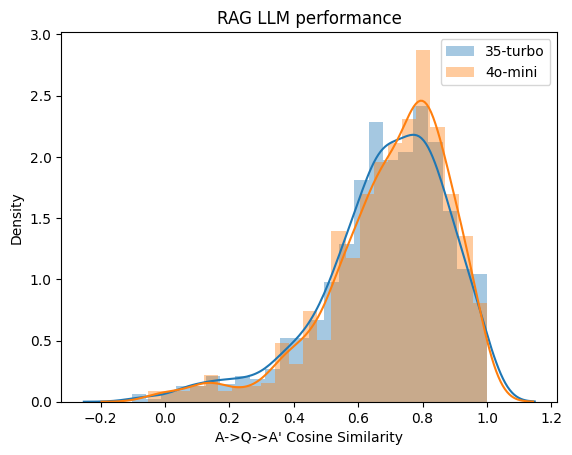

In [100]:
sns.distplot(df_gpt35_results['cosine'], label='35-turbo')
sns.distplot(df_gpt4o_mini_results['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM as a Judge

In [101]:
prompt_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [116]:
df_4o_mini_samples = df_gpt4o_mini_results.sample(200)
df_35_samples = df_gpt35_results.sample(200)

In [117]:
_4o_mini_samples = df_4o_mini_samples.to_dict(orient='records')
_35_mini_samples = df_35_samples.to_dict(orient='records')

In [118]:
prompt = prompt_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Avoid paying a penaltyAvoid paying interestHave a fresh startCreate dialogue with URA team and gain more understanding and information on how to deal with taxes
Generated Question: What are the benefits of Voluntary Disclosure in terms of penalties?
Generated Answer: The benefits of Voluntary Disclosure in terms of penalties include the following:

1. **Avoid Paying a Penalty**: Taxpayers can avoid incurring penalties associated with their tax liabilities.
2. **Avoid Paying Interest**: Taxpayers are also able to avoid interest that may accrue on unpaid taxes.
3. **Have a Fresh Start**: Voluntary Di

In [119]:
answer = llm(prompt,'gpt-4o-mini')
answer

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer accurately reflects the points listed in the original answer regarding the benefits of Voluntary Disclosure, specifically in relation to penalties. It maintains the same structure and includes all key elements from the original answer, making it directly relevant."\n}'

In [120]:
import json

In [130]:
def evals(samples,model):
    evaluations = []

    for record in tqdm(samples):
        prompt = prompt_template.format(**record)
        evaluation = llm(prompt,model)
        evaluations.append(evaluation)
    return evaluations

In [127]:
df_evaluations_35 = pd.DataFrame(evals(_35_mini_samples,'gpt-3.5-turbo'))

100%|██████████| 200/200 [04:41<00:00,  1.41s/it]


In [128]:
df_evaluations_35.Relevance.value_counts()

Relevance
RELEVANT           89
PARTLY_RELEVANT    87
NON_RELEVANT       24
Name: count, dtype: int64

In [131]:
percentages = df_evaluations_35.Relevance.value_counts(normalize=True) * 100
print(percentages)


Relevance
RELEVANT           44.5
PARTLY_RELEVANT    43.5
NON_RELEVANT       12.0
Name: proportion, dtype: float64


In [132]:
df_evaluations_4o = pd.DataFrame(evals(_4o_mini_samples,'gpt-4o-mini'))

100%|██████████| 200/200 [05:54<00:00,  1.77s/it]


In [134]:
df_evaluations_4o

0
0    {\n  "Relevance": "NON_RELEVANT",\n  "Explanat...
1    {\n  "Relevance": "RELEVANT",\n  "Explanation"...
2    {\n  "Relevance": "RELEVANT",\n  "Explanation"...
3    {\n  "Relevance": "RELEVANT",\n  "Explanation"...
4    {\n  "Relevance": "PARTLY_RELEVANT",\n  "Expla...
..                                                 ...
195  {\n  "Relevance": "RELEVANT",\n  "Explanation"...
196  {\n  "Relevance": "RELEVANT",\n  "Explanation"...
197  {\n  "Relevance": "RELEVANT",\n  "Explanation"...
198  {\n  "Relevance": "PARTLY_RELEVANT",\n  "Expla...
199  {\n  "Relevance": "RELEVANT",\n  "Explanation"...

[200 rows x 1 columns]

In [150]:
df_evaluations_4o_res = df_evaluations_4o.to_dict(orient='records')
df_evaluations_4o_res

[{0: '{\n  "Relevance": "NON_RELEVANT",\n  "Explanation": "The generated answer discusses the process for endorsing third party interest on a motor vehicle, which is entirely unrelated to the original answer about the refund or offset of excess tax paid against liabilities. There is no connection between the topics addressed in the original and generated responses."\n}'},
 {0: '{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer effectively summarizes the original answer\'s key points regarding the taxation of capital gains on an asset sold within 12 months of purchase. It includes the calculation method and arrives at the same tax due figure of 4,500,000 UGX, which aligns perfectly with the original information provided."\n}'},
 {0: '{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer accurately answers the question about where to download the TIN template by referencing the URA web portal and the correct steps to find the TIN template. It addresses

In [152]:
json_evaluations = []

for i, str_eval in enumerate(df_evaluations_4o_res):
    for _, v in str_eval.items():
        json_eval = json.loads(v)
        json_evaluations.append(json_eval)

In [158]:
df = pd.DataFrame(json_evaluations)
df.Relevance.value_counts(normalize=True) * 100

Relevance
RELEVANT           87.5
PARTLY_RELEVANT     9.5
NON_RELEVANT        3.0
Name: proportion, dtype: float64